In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import time
import math
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix


def cal_dist(lat1,lat2,lon1,lon2):
    R = 6373.0
    
    lat1 = np.deg2rad(lat1)
    lon1 = np.deg2rad(lon1)
    lat2 = np.deg2rad(lat2)
    lon2 = np.deg2rad(lon2)
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

trip_ids = test.tripid

train['distance'] = cal_dist(train["pick_lat"],train['drop_lat'],train['pick_lon'],train['drop_lon'])
test['distance'] = cal_dist(test["pick_lat"],test['drop_lat'],test['pick_lon'],test['drop_lon'])

train = train[train['distance']<55].dropna()

train['pickup_time'] = pd.to_datetime(train['pickup_time'])
train['drop_time'] = pd.to_datetime(train['drop_time'])

test['pickup_time'] = pd.to_datetime(test['pickup_time'])
test['drop_time'] = pd.to_datetime(test['drop_time'])


train['new_duration'] = (train['drop_time']-train['pickup_time']).dt.total_seconds()
test['new_duration'] = (test['drop_time']-test['pickup_time']).dt.total_seconds()

train = train[train['new_duration']<10000].dropna()

train['no_duration_diff_exists'] = abs(train['duration']-train['new_duration'])<60
test['no_duration_diff_exists'] = abs(test['duration']-test['new_duration'])<60

drop_list = ['tripid','pick_lon','pick_lat','drop_lon','drop_lat','pickup_time','drop_time']
train = train.drop(drop_list,axis=1) 
test = test.drop(drop_list,axis=1) 

i_columns = train.columns.drop(['label','no_duration_diff_exists'])
for col in i_columns:
    train[col] = pd.to_numeric(train[col])
    if(col!='label'):
        test[col] = pd.to_numeric(test[col])
        
train['fare_without_waiting'] = train['fare']-train['meter_waiting_fare']
test['fare_without_waiting'] = test['fare']-test['meter_waiting_fare']

train = train[train['fare']<2000].dropna()

train = train.drop(["meter_waiting_till_pickup"],axis =1)
test = test.drop(["meter_waiting_till_pickup"],axis =1)

train["duration_without_waiting"] = train["duration"]-train["meter_waiting"]
test["duration_without_waiting"] = test["duration"]-test["meter_waiting"]

train['fare_per_distance'] = train['fare_without_waiting']/train['distance']
train['fare_per_sec'] = train['fare_without_waiting']/train['duration']
train['distance_duration'] = train['distance']/train['duration_without_waiting']

test['fare_per_distance'] = test['fare_without_waiting']/test['distance']
test['fare_per_sec'] = test['fare_without_waiting']/test['duration']
test['distance_duration'] = test['distance']/test['duration_without_waiting']

# (fare - waiting_fare) / distance
# (fare - waiting_fare) / (duration - meter_waiting)
# distance / (duration - meter_waiting)
# meter_waiting / duration
# additional_fare / distance 
# additional_fare / fare+additional_fare

In [2]:
train = train[train['distance']!=0]
train = train[train['duration']!=0]
train = train[train['duration_without_waiting']>0]

In [3]:
train['duration_without_waiting'].describe()

count    16769.000000
mean      1043.788956
std        869.157565
min          1.000000
25%        446.000000
50%        807.000000
75%       1391.000000
max       8389.000000
Name: duration_without_waiting, dtype: float64

In [4]:
imputer = SimpleImputer(strategy='constant',fill_value = 0)
imputed_df_train = pd.DataFrame(imputer.fit_transform(train))
imputed_df_test = pd.DataFrame(imputer.fit_transform(test))

imputed_df_train.columns = train.columns
imputed_df_test.columns = test.columns

i_columns = train.columns.drop(['label'])
for col in i_columns:
    imputed_df_train[col] = pd.to_numeric(imputed_df_train[col])
    if(col=='no_duration_diff_exists'):
        imputed_df_train[col] = imputed_df_train[col].astype(int)
        imputed_df_test[col] = imputed_df_test[col].astype(int)
    if(col!='label'):
        imputed_df_test[col] = pd.to_numeric(imputed_df_test[col])
        
feature_cols = train.columns.drop('label')
label_dict = {"correct":1,"incorrect":0}
imputed_df_train['label'] = imputed_df_train.label.replace(label_dict)

F1 score is:  0.9755075733161457


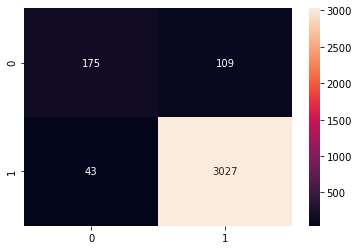

In [6]:
#  Classification using XGBoost 
import xgboost as xgb

X_train, X_test, y_train, y_test = train_test_split(imputed_df_train[feature_cols],
                                                    imputed_df_train['label'], 
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    stratify=imputed_df_train['label'],
                                                    random_state=40)
params = {'subsample': 1,
 'reg_lambda': 3,
 'reg_alpha': 0.9,
 'n_estimators': 200,
 'min_child_weight': 2,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 1,
 'colsample_bytree': 0.7}

clf_base = xgb.XGBClassifier(random_state=30,params = params)      
clf_base = clf_base.fit(X_train,y_train)

ac = f1_score(y_test,clf_base.predict(X_test))
print('F1 score is: ',ac)
cm = confusion_matrix(y_test,clf_base.predict(X_test))
sns.heatmap(cm,annot=True,fmt="d");

In [7]:
#  Classification using XGBoost 
import xgboost as xgb

X_train = imputed_df_train[feature_cols]
y_train = imputed_df_train['label']
                                                 
params = {'subsample': 1,
 'reg_lambda': 3,
 'reg_alpha': 0.9,
 'n_estimators': 200,
 'min_child_weight': 2,
 'max_depth': 8,
 'learning_rate': 0.1,
 'gamma': 1,
 'colsample_bytree': 0.7}

clf_final = xgb.XGBClassifier(random_state=30,params = params)      
clf_final = clf_final.fit(X_train,y_train)

In [8]:
final_pred = clf_final.predict(imputed_df_test)

In [9]:
output = pd.DataFrame({'tripid': trip_ids,'prediction': final_pred})
output.to_csv('submission.csv', index=False)